In [ ]:
%pip install visualkeras

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import visualkeras

In [2]:
def load_and_preprocess_data():
    """Load and preprocess the CIFAR10 dataset."""
    # Load the CIFAR10 dataset
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
    
    # Normalize pixel values to be between 0 and 1
    x_train, x_test = x_train / 255.0, x_test / 255.0
    
    # Split the training set into a training and validation set
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=42)
    
    # Convert the label vectors to one-hot encoded format
    y_train = tf.keras.utils.to_categorical(y_train, 10)
    y_test = tf.keras.utils.to_categorical(y_test, 10)
    y_val = tf.keras.utils.to_categorical(y_val, 10)
    
    return x_train, y_train, x_val, y_val, x_test, y_test

In [3]:
def create_model():
    """Create a simple CNN model."""
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.Flatten(),
        layers.Dense(64),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

def train_model(model, x_train, y_train, x_val, y_val):
    """Train the model and add callbacks."""
    history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))
    return history

def visualize_model(model):
    """Visualize the model architecture."""
    visualkeras.layered_view(model).show()

def evaluate_model(model, x_test, y_test):
    """Evaluate the model on the test set."""
    loss, accuracy = model.evaluate(x_test, y_test)
    print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

In [4]:
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)  # Random horizontal flip
    image = tf.image.random_brightness(image, max_delta=0.2)  # Random brightness
    image = tf.image.random_contrast(image, lower=0.8, upper=1.2)  # Random contrast
    image = tf.image.resize_with_crop_or_pad(image, 40, 40)  # Pad to 40x40
    image = tf.image.random_crop(image, size=[32, 32, 3])  # Random crop back to 32x32
    return image, label

x_train, y_train, x_val, y_val, x_test, y_test = load_and_preprocess_data()

# Convert training data to a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset
    .map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)  # Apply augmentation
    .shuffle(buffer_size=5000)  # Shuffle the dataset
    .batch(32)  # Batch size
    .prefetch(buffer_size=tf.data.AUTOTUNE)  # Prefetch for performance
)

In [7]:
model = create_model()
history = model.fit(train_dataset, epochs=50, validation_data=(x_val, y_val))

Epoch 1/50
1407/1407 [==============================] - 10s 6ms/step - loss: 1.6596 - accuracy: 0.3898 - val_loss: 1.2759 - val_accuracy: 0.5284
Epoch 2/50
1407/1407 [==============================] - 7s 5ms/step - loss: 1.3415 - accuracy: 0.5175 - val_loss: 1.1209 - val_accuracy: 0.5898
Epoch 3/50
1407/1407 [==============================] - 8s 5ms/step - loss: 1.2153 - accuracy: 0.5709 - val_loss: 1.0225 - val_accuracy: 0.6300
Epoch 4/50
1407/1407 [==============================] - 8s 5ms/step - loss: 1.1367 - accuracy: 0.5988 - val_loss: 1.0564 - val_accuracy: 0.6224
Epoch 5/50
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0824 - accuracy: 0.6198 - val_loss: 0.9766 - val_accuracy: 0.6546
Epoch 6/50
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0470 - accuracy: 0.6318 - val_loss: 0.8809 - val_accuracy: 0.6862
Epoch 7/50
1407/1407 [==============================] - 8s 6ms/step - loss: 1.0064 - accuracy: 0.6498 - val_loss: 0.9309 - val_accuracy

Text(0.5, 1.0, 'Loss')

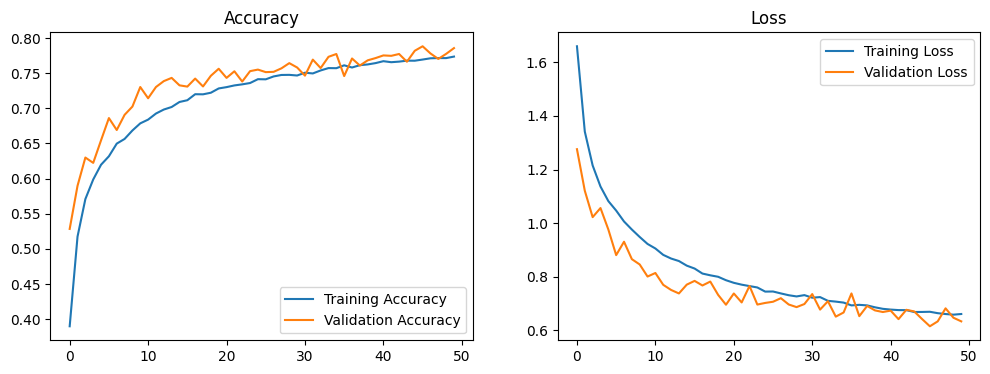

In [8]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss')

In [9]:
evaluate_model(model, x_test, y_test)

313/313 [==============================] - 1s 3ms/step - loss: 0.6396 - accuracy: 0.7820
Test Loss: 0.6395995616912842, Test Accuracy: 0.7820000052452087
